<a href="https://colab.research.google.com/github/Avery1493/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Quinn_233_LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [28]:
#Imports
import numpy as np
import pandas as pd
pd.options.display.max_columns=200
pd.options.display.max_rows=200

#Loading Data
Q3 = pd.read_csv('https://raw.githubusercontent.com/Avery1493/Lending-Club/master/Data/LC2019Q3_Paid_or_Charged_Off')
Q4 = pd.read_csv('https://raw.githubusercontent.com/Avery1493/Lending-Club/master/Data/LC2019Q4_Paid_or_Charged_Off')

#Combining Data Sets
df = pd.concat([Q3,Q4])
print(df.shape)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(11484, 150)


In [0]:
#Stripping
df['term'] = df['term'].str.strip(' months')
df['int_rate'] = df['int_rate'].str.strip('%')
df['revol_util'] = df['revol_util'].str.strip('%')

#Combining 
df['FICO'] = df[['fico_range_low','fico_range_high']].mean(axis=1)
df['Last_FICO'] = df[['last_fico_range_low','last_fico_range_high']].mean(axis=1)
#installment

#Dropping
df = df.drop(['member_id','url','desc','zip_code', 'fico_range_low',
              'fico_range_high','hardship_flag','hardship_type',
              'hardship_reason','hardship_status','deferral_term',
              'hardship_amount','hardship_start_date','hardship_end_date',
              'payment_plan_start_date','hardship_length','hardship_dpd',
              'hardship_loan_status','next_pymnt_d',
              'orig_projected_additional_accrued_interest',
              'hardship_payoff_balance_amount',
              'hardship_last_payment_amount','funded_amnt','funded_amnt_inv',
              'total_rec_prncp','total_rec_int','total_pymnt_inv','total_pymnt',
              'pymnt_plan','recoveries','delinq_amnt','tax_liens',
              'pub_rec_bankruptcies','deferral_term','settlement_status',
              'settlement_date','settlement_amount','settlement_percentage',
              'settlement_term','il_util','bc_util','sec_app_revol_util',
              'last_fico_range_low','last_fico_range_high',
              'last_credit_pull_d','out_prncp','out_prncp_inv',
              'collection_recovery_fee','acc_now_delinq',
              'num_tl_120dpd_2m','num_tl_30dpd'], axis = 1)

#Missing
df = df.fillna(np.NaN)
#Datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

In [30]:
print(df.shape)
df.sample(3)

(11484, 102)


,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,debt_settlement_flag,debt_settlement_flag_date,FICO,Last_FICO
2152,160285972,12000,60,17.74,303.03,C,C5,General Manager,1 year,MORTGAGE,82000.0,Source Verified,2019-10-01,Fully Paid,other,Other,ME,11.40,0,2006-01-01,0,68.0,108.0,7,1,43637,59.1,9,w,0.0,Oct-2019,12033.82,0,NaN,1,Individual,NaN,NaN,NaN,0,49899,0,1,0,0,41.0,6262,1,2,8524,49.0,95700,0,0,2,2,8317.0,3045.0,0,41.0,165,11,11,1,36.0,NaN,11.0,NaN,0,2,4,3,3,1,6,7,4,6,0,1,88.9,50.0,111530,49899,12300,15830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,697.0,697.0
118,163687152,31600,36,8.81,1002.08,A,A5,Bookkeeper,10+ years,MORTGAGE,60000.0,Source Verified,2019-12-01,Fully Paid,debt_consolidation,Debt consolidation,MI,18.32,0,2003-09-01,1,66.0,NaN,8,0,4553,10.8,36,w,0.0,Dec-2019,31647.95,0,NaN,1,Joint App,120000.0,21.24,Source Verified,0,102460,2,3,2,4,4.0,28304,1,3,1027,42.0,42000,2,11,2,7,12808.0,19973.0,0,132.0,195,3,3,4,53.0,NaN,4.0,NaN,0,1,2,1,8,12,4,20,2,8,0,3,94.4,0.0,169103,32857,21000,36103,40475.0,740.0,744.0,Sep-2003,0.0,4.0,4.0,1.0,8.0,0.0,0.0,NaN,N,NaN,762.0,762.0
1542,161022748,32400,60,10.33,693.68,B,B1,Surgical technician,10+ years,MORTGAGE,109999.0,Source Verified,2019-11-01,Fully Paid,debt_consolidation,Debt consolidation,NH,13.43,0,2002-01-01,1,NaN,NaN,27,0,6637,8.1,60,w,0.0,Dec-2019,32946.15,0,NaN,1,Individual,NaN,NaN,NaN,0,57980,5,3,2,3,3.0,51343,8,17,3790,42.0,81600,1,1,5,20,2147.0,66063.0,0,135.0,213,1,1,2,1.0,NaN,1.0,NaN,0,4,4,16,25,10,24,48,4,27,0,10,100.0,0.0,139838,57980,72700,58238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,762.0,762.0


In [128]:
train = df[df['issue_d'].dt.month <= 8]
val = df[(df['issue_d'].dt.month >8) & (df['issue_d'].dt.month <11)]
test = df[df['issue_d'].dt.month >= 11]

train.shape, val.shape, test.shape

((6450, 102), (3485, 102), (1549, 102))

# Exploritory Visualizations

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

#Separtaing train by class
paid = train[train['loan_status'] == 'Fully Paid']
charged_off = train[train['loan_status'] != 'Fully Paid']

paid.shape, charged_off.shape

((6104, 102), (346, 102))

In [131]:
paid.describe()

,id,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,FICO,Last_FICO
count,6.104000e+03,6104.000000,6104.000000,6.104000e+03,6091.000000,6104.000000,6104.000000,2665.000000,738.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,1297.000000,6104.0,763.000000,763.000000,6104.000000,6.104000e+03,6104.000000,6104.000000,6104.000000,6104.000000,6011.000000,6104.000000,6104.000000,6104.000000,6104.000000,6099.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6101.000000,5999.000000,6104.000000,6011.000000,6104.000000,6104.000000,6104.000000,6104.000000,6007.000000,1242.000000,5627.000000,1787.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,5999.000000,6.104000e+03,6104.000000,6104.000000,6104.000000,763.00000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,229.000000,6104.000000,6104.000000
mean,1.558625e+08,14098.742628,423.070880,9.074254e+04,19.232356,0.230013,0.586501,37.606379,84.821138,11.836337,0.122543,15538.025393,25.853211,0.295865,12221.783924,0.013106,47.054742,1.0,136579.586907,18.205583,160.298493,1.692489e+05,1.102392,2.939220,1.061107,2.179227,15.339211,40545.676278,1.329456,2.676442,5672.323558,51.850467,43172.066022,1.526704,1.938401,2.370249,5.178899,16338.633667,20024.073512,0.009666,127.728997,173.679063,14.609928,7.048001,1.660878,24.238389,40.265700,6.495291,38.128707,0.469037,3.305865,4.829292,4.959699,7.694954,10.053408,8.196756,13.932995,4.811763,11.816350,0.060616,2.537189,95.125999,25.872812,2.166945e+05,56396.116153,30376.924148,50233.273919,35986.53211,681.173001,685.173001,0.692005,1.874181,11.326343,3.068152,12.905636,0.019659,0.057667,38.934498,715.155390,718.610092
std,1.080482e+06,9832.618431,286.109678,1.534063e+05,20.952817,0.773036,0.842731,21.948873,24.302492,6.103207,0.332897,24031.131266,13.230859,3.276328,9984.893128,0.116584,22.358766,0.0,65999.086330,8.435014,1337.126319,1.836044e+05,1.225581,3.013663,1.130818,1.826845,21.517463,46744.598459,1.549577,2.672095,5832.012155,21.852549,40816.929617,1.721073,3.106785,2.569284,3.491490,19854.637501,23921.870029,0.163140,55.550130,94.717151,17.643214,7.417148,1.892404,32.767724,22.292617,5.653847,22.475997,1.353844,2.339242,3.190857,3.383706,4.971457,8.055361,5.166072,8.723581,3.172642,6.097535,0.416671,2.053263,8.208017,32.630651,2.044593e+05,55275.980660,28899.832969,48818.633270,33298.84394,46.848518,46.848518,1.003028,1.924398,6.203646,3.052140,8.869660,0.156676,0.301924,22.172966,38.192641,42.913300
min,1.525281e+08,1000.000000,30.890000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000

In [132]:
charged_off.describe()

,id,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,FICO,Last_FICO
count,3.460000e+02,346.000000,346.000000,346.000000,345.000000,346.000000,346.000000,133.000000,31.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,64.000000,346.0,46.000000,46.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,316.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,339.000000,346.00000,316.000000,346.000000,346.000000,346.000000,346.000000,339.000000,51.000000,297.000000,75.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,339.000000,346.000000,346.000000,346.000000,346.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,13.000000,346.000000,346.000000
mean,1.555713e+08,17102.962428,511.483786,82752.264162,19.508058,0.182081,0.656069,36.796992,83.967742,10.965318,0.089595,16430.921965,20.939306,0.753006,477.179566,0.023121,45.812500,1.0,131406.633913,20.409565,185.867052,130331.014451,1.078035,2.413295,0.748555,1.563584,19.430380,35657.118497,1.352601,2.751445,6172.000000,52.372832,45161.789017,1.372832,1.578035,2.442197,4.546243,13424.702312,19359.766962,0.00289,115.765823,163.410405,15.592486,8.618497,1.153179,23.852507,40.137255,6.003367,35.866667,0.404624,3.552023,4.997110,5.060694,7.158960,7.465318,7.991329,12.144509,4.971098,10.950867,0.040462,2.234104,95.802601,30.096165,178788.239884,52438.884393,31435.419075,45400.210983,44884.043478,664.891304,668.891304,1.086957,1.108696,11.891304,2.847826,14.456522,0.021739,0.217391,29.923077,709.947977,572.549133
std,1.096296e+06,10843.428530,312.531271,48098.209039,14.839968,0.547799,0.910601,21.702799,27.871711,5.760330,0.286015,20377.851368,11.466868,4.414887,2511.544646,0.168669,19.600676,0.0,68352.200916,9.485278,1145.838638,151829.386305,1.304277,2.610957,0.943512,1.475502,26.367938,42947.469284,1.574233,2.611360,6672.416059,24.264778,50528.367557,1.699876,2.783176,3.011737,3.277397,18068.431595,24275.918294,0.05376,55.904416,102.101707,21.618399,11.233186,1.606943,30.849732,24.435237,5.788793,23.960741,1.337695,2.514632,3.189201,3.289741,4.671299,6.651160,4.760031,7.546335,3.170384,5.755946,0.271515,2.043042,7.652376,35.325603,177690.553438,50881.186574,29784.188659,48793.565389,41218.006955,51.494219,51.494219,1.170491,1.268915,6.779801,2.564435,8.888711,0.147442,0.986870,18.227550,38.368657,136.274533
min,1.521515e+08,1000.000000,33.080000,0.000000,0.000000,0.000000,0.000000,4.000000,26.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,1.0,34704.000000,3.070000,0.

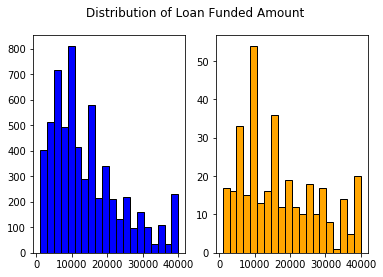

In [133]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=False)
fig.suptitle('Distribution of Loan Funded Amount')
ax1.hist(paid['loan_amnt'], edgecolor='black',color='blue',
             bins=int(20));
ax2.hist(charged_off['loan_amnt'], edgecolor='black',color='orange',
         bins=int(20));


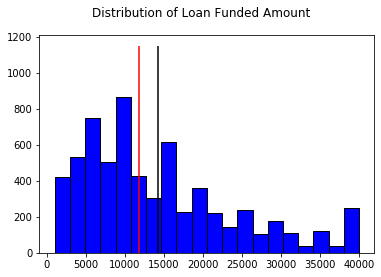

In [134]:
mean = train['loan_amnt'].mean()
median = train['loan_amnt'].median()
fig, ax = plt.subplots()
fig.suptitle('Distribution of Loan Funded Amount')
ax.hist(train['loan_amnt'], edgecolor='black',color='blue',
             bins=int(20))
ax.vlines(mean,0,1150, color='black')
ax.vlines(median,0,1150, color='red')
plt.show();

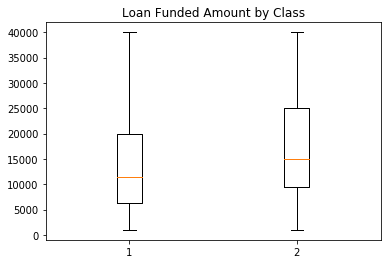

In [135]:
data = [paid['loan_amnt'],charged_off['loan_amnt']]
fig, ax = plt.subplots()
ax.set_title('Loan Funded Amount by Class')
plt.boxplot(data,notch=False, vert=True);


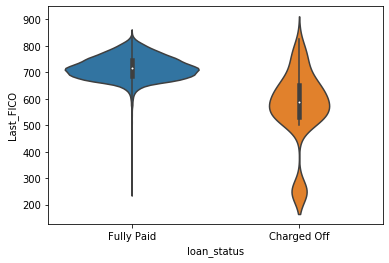

In [136]:
sns.violinplot(x=train['loan_status'], y=train['Last_FICO'])

# XGBoost

In [137]:
target = 'loan_status'
features = train.columns.drop([target, 'id','issue_d','earliest_cr_line'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

features.value_counts().sum()

98

In [141]:
!pip install category_encoders
!pip install eli5
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimaters=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

     |████████████████████████████████| 112kB 2.8MB/s 


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['term', 'int_rate', 'grade', 'sub_grade',
                                      'emp_title', 'emp_length',
                                      'home_ownership', 'verification_status',
                                      'purpose', 'title', 'addr_state',
                                      'revol_util', 'initial_list_status',
                                      'last_pymnt_d', 'application_type',
                                      'verification_status_joint',
                                      'sec_app_earliest_cr_line',
                                      'debt_settlement_flag',
                                      'de...
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weig

In [142]:
from sklearn.metrics import balanced_accuracy_score

y_pred = pipeline.predict(X_val)
print('Validation accuracy:', balanced_accuracy_score(y_val,y_pred))

Validation accuracy: 0.8971137323547833


# Permutation

In [144]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_trained_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

model = RandomForestClassifier(n_estimators=100,
                               random_state=42, n_jobs=-1)
model.fit(X_trained_transformed,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [145]:
import eli5
from eli5.sklearn import PermutationImportance
#Calculate importances
permuter = PermutationImportance(
    model,
    scoring = 'balanced_accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed,y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [146]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_,feature_names).sort_values(ascending=False)

last_pymnt_amnt                        0.349535
last_pymnt_d                           0.127397
Last_FICO                              0.053601
mths_since_recent_bc                   0.006849
total_bal_ex_mort                      0.006849
avg_cur_bal                            0.006849
FICO                                   0.006849
total_il_high_credit_limit             0.005479
revol_bal                              0.005479
acc_open_past_24mths                   0.005479
num_rev_accts                          0.004110
pct_tl_nvr_dlq                         0.004110
all_util                               0.004110
total_bal_il                           0.004110
open_il_12m                            0.004110
total_acc                              0.004110
addr_state                             0.004110
emp_length                             0.004110
installment                            0.004110
mths_since_recent_inq                  0.004110
tot_hi_cred_lim                        0

In [147]:
#Display Permutation importances
eli5.show_weights(
    permuter,
    top=None, #shows all features
    feature_names = feature_names
)

Weight,Feature
0.3495 ± 0.0175,last_pymnt_amnt
0.1274 ± 0.0164,last_pymnt_d
0.0536 ± 0.0054,Last_FICO
0.0068 ± 0.0000,mths_since_recent_bc
0.0068 ± 0.0000,total_bal_ex_mort
0.0068 ± 0.0000,avg_cur_bal
0.0068 ± 0.0000,FICO
0.0055 ± 0.0055,total_il_high_credit_limit
0.0055 ± 0.0055,revol_bal
0.0055 ± 0.0055,acc_open_past_24mths
